In [21]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from sklearn import datasets

# Problem 1

In this problem we will look at image compression using SVD, following the lines of the well-known "Eigenfaces" experiment. The basic concept is to represent an image (in grayscale) of size $m \times n$ as an $m \times n$ real matrix $M$. SVD is then applied to this matrix to obtain $U$, $S$, and $V$ such that $M = U S V^T$. Here $U$ and $V$ are the matrices whose columns are the left and right singular vectors respectively, and $S$ is a diagonal $m \times n$ matrix consisting of the singular values of $M$. The number of non-zero singular values is the rank of $M$. By using just the largest $k$ singular values (and corresponding left and right singular vectors), one obtains the best rank-$k$ approximation to $M$.

The following code returns the dataset of 400 images.

In [22]:
data = datasets.fetch_olivetti_faces()
images = data.images

(a) Given an $m \times n$ image $M$ and its rank-$k$ approximation $A$, we can measure the reconstruction error using mean $\ell_1$ error: $$ \text{error}_{\ell_1}(M, A) = \frac{1}{mn}\| M - A \|_1 = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{n}| M_{i,j} - A_{i,j} |. $$ For $k = 1, \dots, 30$, take the average rank-$k$ reconstruction error over all images in the dataset, and plot a curve of average reconstruction error as a function of $k$.

In [23]:
# Returns the best rank-k approximation to M
def svd_reconstruct(M, k):
    # Perform SVD
    u, s, vt = np.linalg.svd(images[M], full_matrices=False)  # Advice: pass in full_matrices=False to svd to avoid dimensionality issues
    
    # Reconstruct
    reconst = u[:,0:k] @ np.diag(s[0:k]) @ vt[0:k,:]
    return reconst
        

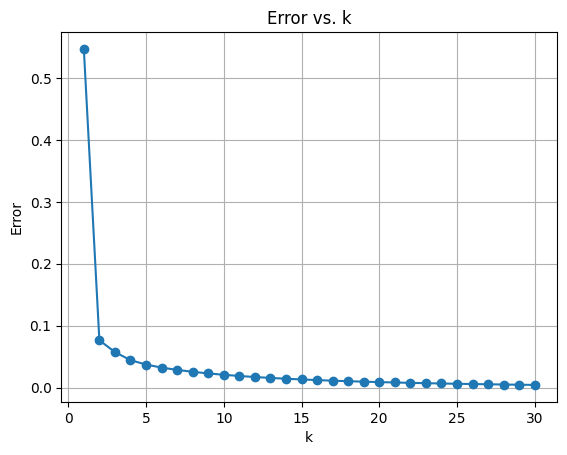

In [24]:
rows = images.shape[1]
cols = images.shape[2]

# List to hold average errors for plotting
mean_error_list = []

# Run SVD
for k in range(30):
    error_list = []
    for m in range(images.shape[0]):
        reconstruction = svd_reconstruct(m,k)
        error = (1/(rows*cols)) * np.sum(np.absolute(images[m] - reconstruction))
        error_list.append(error)
    mean_error_list.append(np.mean(error_list))

# Plot
plt.plot([num for num in range(1,31)], mean_error_list, marker='o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error')
plt.title('Error vs. k')
plt.show()


(b) Pick any image in the dataset, and display the following side-by-side as images: the original, and the best rank-$k$ approximations for $k = 10, 20, 30, 40$. You will find the `imshow` method in matplotlib useful for this; pass in `cmap='gray'` to render in grayscale. Feel free to play around further.

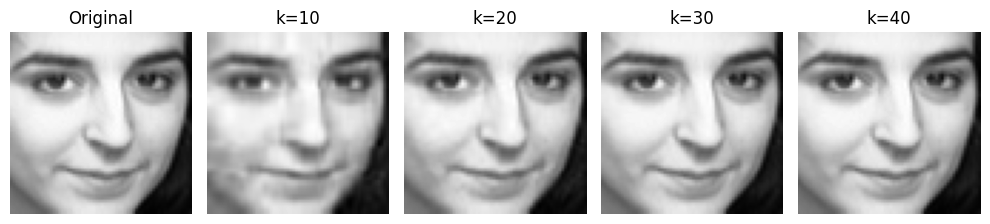

In [25]:
k_range = np.arange(10,41,10)
image_layer = 96

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
ax = ax.flatten()

# Use imshow to display the grayscale image
img_list = [images[image_layer]]
ax[0].imshow(images[image_layer], cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
i = 1
for k in k_range:
    img_list.append(svd_reconstruct(M=image_layer, k=k))
    ax[i].imshow(img_list[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'k={k}')
    i += 1
plt.tight_layout()
plt.show()

# Problem 2

In this problem we visualize the Wisconsin breast cancer dataset in two dimensions using PCA. First, rescale the data so that every feature has mean 0 and standard deviation 1 across the various points in the dataset. You may find `sklearn.preprocessing.StandardScaler` useful for this. Next, compute the top two principal components of the dataset using PCA, and for every data point, compute its coordinates (i.e. projections) along these two principal components. You should do this in two ways:
1. By using SVD directly. Do not use any PCA built-ins.
2. By using `sklearn.decomposition.PCA`.

The two approaches should give exactly the same result, and this also acts as a check. (But note that the signs of the singular vectors may be flipped in the two approaches since singular vectors are only determined uniquely up to sign. If this happens, flip signs to make everything identical again.)

Your final goal is to make a scatterplot of the dataset in 2 dimensions, where the x-axis is the first principal component and the y-axis is the second. Color the points by their diagnosis (malignant or benign). Do this for both approaches. Your plots should be identical. Does the data look roughly separable already in 2 dimensions?

In [26]:
cancer = datasets.load_breast_cancer()

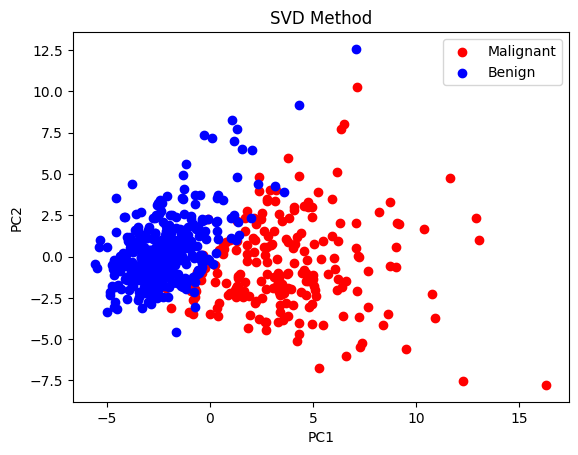

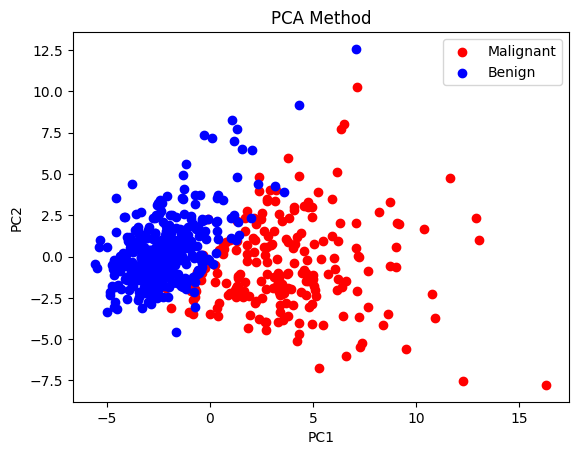

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Using SVD...
# Rescale the data
cancer_scaled = StandardScaler().fit_transform(cancer.data)

# Compute SVD to obtain principal components
U, S, Vt = np.linalg.svd(cancer_scaled, full_matrices=False)

# Take the top two singular vectors from Vt as principal components
principal_components_svd = Vt[:2]

# Project data onto the first two principal components
projected_data_svd = cancer_scaled @ principal_components_svd.T

#-----------------------------------------------------------------------

### Using PCA...
# Create a PCA instance with 2 components
pca = PCA(n_components=2)

# Fit PCA to the scaled data
pca.fit(cancer_scaled)

# Obtain the principal components
principal_components_pca = pca.components_

# Project data onto the first two principal components
projected_data_pca = pca.transform(cancer_scaled)

# Correct the signs on SVD data
for i in range(projected_data_svd.shape[0]):
    for j in range(projected_data_svd.shape[1]):
        if projected_data_svd[i,j] * projected_data_pca[i,j] <= 0:
            projected_data_svd[i,j] = -1 * projected_data_svd[i,j]

# Bind on categorical column for plotting
projected_data_svd = np.column_stack((projected_data_svd, cancer.target))
projected_data_pca = np.column_stack((projected_data_pca, cancer.target))

# Separate data points by category for SVD
x_category_0svd = [projected_data_svd[:,0][i] for i in range(len(projected_data_svd[:,0])) if projected_data_svd[:,2][i] == 0]
y_category_0svd = [projected_data_svd[:,1][i] for i in range(len(projected_data_svd[:,1])) if projected_data_svd[:,2][i] == 0]
x_category_1svd = [projected_data_svd[:,0][i] for i in range(len(projected_data_svd[:,0])) if projected_data_svd[:,2][i] == 1]
y_category_1svd = [projected_data_svd[:,1][i] for i in range(len(projected_data_svd[:,1])) if projected_data_svd[:,2][i] == 1]

# Plot SVD
plt.scatter(x_category_0svd, y_category_0svd, c='red', label='Malignant')
plt.scatter(x_category_1svd, y_category_1svd, c='blue', label='Benign')
plt.legend()
plt.title('SVD Method')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# # Separate data points by category for PCA
x_category_0pca = [projected_data_pca[:,0][i] for i in range(len(projected_data_pca[:,0])) if projected_data_pca[:,2][i] == 0]
y_category_0pca = [projected_data_pca[:,1][i] for i in range(len(projected_data_pca[:,1])) if projected_data_pca[:,2][i] == 0]
x_category_1pca = [projected_data_pca[:,0][i] for i in range(len(projected_data_pca[:,0])) if projected_data_pca[:,2][i] == 1]
y_category_1pca = [projected_data_pca[:,1][i] for i in range(len(projected_data_pca[:,1])) if projected_data_pca[:,2][i] == 1]

# Plot PCA
plt.scatter(x_category_0pca, y_category_0pca, c='red', label='Malignant')
plt.scatter(x_category_1pca, y_category_1pca, c='blue', label='Benign')
plt.legend()
plt.title('PCA Method')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
